In [378]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import sys
import io

from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb
from matplotlib import pyplot as plt
from skimage import color
from skimage.io import imread
from skimage.io import imshow
from scipy.sparse import csr_matrix

import torch
from torch import optim
from torch.nn import functional as tf
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from utils import VOC_LABEL2COLOR
from utils import VOC_STATISTICS
from utils import numpy2torch
from utils import torch2numpy

In [379]:
def color2label(gt_in_colors):
    # Transforming [H,W,C] label colors to [H,W] true labels
    def get_label_from_color(rgb):
        # Somehow imread() on a png file gives (x,y,4); We ignore the last entry which is always 255
        label_color = tuple([rgb[0], rgb[1], rgb[2]])
        # TODO: Make the lookup faster?
        if label_color in VOC_LABEL2COLOR:
            return VOC_LABEL2COLOR.index(label_color)
        else:
            return 0
    gt_labels = np.apply_along_axis(get_label_from_color, 2, gt_in_colors)
    return gt_labels

In [380]:
# VOC Dataset class, derived from PyTorch Dataset
class VOC2007Dataset(Dataset):
    def __init__(self, root, train, num_examples):
        super().__init__()
        
        # Reading num_examples lines from the split file for the image names
        if train:
            split_file = open(root + "/ImageSets/Segmentation/train.txt", "r")
        else:
            split_file = open(root + "/ImageSets/Segmentation/val.txt", "r")
        splits = []
        
        # TODO: Read random line?
        for _ in range(0, num_examples):
            line = split_file.readline()
            splits.append(line[:6])
        split_file.close()
                
        # Reading pictures and gt for the entries in splits
        # Saving a dictionary of {im, gt} for every entry in splits
        self.data = []
        c = 0
        for name in splits:
            self.data.append({
                "im" : numpy2torch(imread(root + "/JPEGImages/{}.jpg".format(name))),
                # Colors in gt are converted to true labels
                "gt" : numpy2torch(color2label(imread(root + "/SegmentationClass/{}.png".format(name))))
            })     
    
    
    def __getitem__(self, index):
        # Returning random dictionary of {im, gt} from dataset
        example_dict = np.random.choice(self.data)
        assert (isinstance(example_dict, dict))
        assert ('im' in example_dict.keys())
        assert ('gt' in example_dict.keys())
        return example_dict

    def __len__(self):
        return len(self.data)

In [381]:
# Create and return pytorch.utils DataLoader
def create_loader(dataset, batch_size, shuffle, num_workers):
    loader = DataLoader(dataset, batch_size, shuffle, num_workers=num_workers)
    assert (isinstance(loader, DataLoader))
    return loader

In [382]:
"""
    Transforms RGB to HSV colorspace and adds label color.
    
    :param ndarray np_image: [H,W,C] integer numpy image
    :param ndaraay np_label: [H,W] numpy array of true labels
    :return : [H,W,C] numpy image 
"""
def voc_label2color(np_image, np_label):
    assert (isinstance(np_image, np.ndarray))
    assert (isinstance(np_label, np.ndarray))

    # Transform input into hsv space
    # np_image gets casted to float at division
    hsv_image = rgb_to_hsv(np_image/255.0)

    # Iterate over all pixels
    for x in range(0, np_label.shape[0]):
        for y in range(0, np_label.shape[1]):
            label_color = np.asarray(VOC_LABEL2COLOR[int(np_label[x,y])])
            hsv_label_color = rgb_to_hsv(label_color/255.0)
            hsv_image[x,y,0] = hsv_label_color[0]
            hsv_image[x,y,1] = hsv_label_color[1]
    
    colored = hsv_to_rgb(hsv_image)

    assert (np.equal(colored.shape, np_image.shape).all())
    # assert (np_image.dtype == colored.dtype)
    return colored

In [383]:
def show_dataset_examples(loader, grid_height, grid_width, title):
    plt.figure(figsize=(10, 10))
    # TODO: Fix title and plots
    plt.title(title)

    c = 1
    # Call the data loader until grid_height*grid_width samples are generated
    for dic in loader:
        if c > grid_height*grid_width:
            break
        else:
            plt.subplot(grid_height, grid_width, c)
            colored_img = voc_label2color(torch2numpy(dic["im"][0,:,:,:]), torch2numpy(dic["gt"][0,:,:,:]))
            plt.imshow(colored_img)
            c += 1
    plt.show()
    pass

In [384]:
def standardize_input(input_tensor):
    
    # Normalize input by (x - mean(x)) / std(x) from VOC_STATISTICS
    normalized = torch.zeros(size=input_tensor.shape)
    
    """
    normalized[0,0,:,:] = (input_tensor[0,0,:,:] - VOC_STATISTICS["mean"][0]) / VOC_STATISTICS["std"][0]
    normalized[0,1,:,:] = (input_tensor[0,1,:,:] - VOC_STATISTICS["mean"][1]) / VOC_STATISTICS["std"][1]
    normalized[0,2,:,:] = (input_tensor[0,2,:,:] - VOC_STATISTICS["mean"][2]) / VOC_STATISTICS["std"][2]
    """
    transformation = transforms.Normalize(
        mean = VOC_STATISTICS["mean"],
        std = VOC_STATISTICS["std"]
    )
    
    normalized[0,:,:,:] = transformation(input_tensor[0,:,:,:].float())
    
    assert (type(input_tensor) == type(normalized))
    assert (input_tensor.size() == normalized.size())
    return normalized

In [385]:
def run_forward_pass(normalized, model):
    
    model.eval()
    
    # Activation function values: 21 x (height x width) tensors
    # containing the predicted unnormalized probabilites for the 21 labels for each pixel of the normalized input
    output = model(normalized)
    acts = output['out']
    
    # ---------- Do a 'softmax' on the 21 labels dimension ----------
    
    prediction = torch.zeros(size=normalized.shape)

    # Iterate over all pixels
    for x in range(0, normalized.shape[2]):
        for y in range(0,normalized.shape[3]):
            # Get label with max. probability:
            xy_label = torch.argmax(acts[0,:,x,y]).item()
            # Assign label color to prediction
            prediction[0,0,x,y] = xy_label            

    assert (isinstance(prediction, torch.Tensor))
    assert (isinstance(acts, torch.Tensor))
    
    # Torch variables requiring grad need to be detached 
    # casting prediction to integer values
    return prediction.detach(), acts.detach()

In [386]:
def average_precision(prediction, gt):
    assert (prediction.shape == gt.shape)
    assert (prediction.dtype == gt.dtype)
    sum_of_equal_elements = float(sum(sum(sum(prediction[0,:,:,:] == gt[0,:,:,:]))))
    sum_of_elements = gt[0,:,:,:].numel()
    
    return sum_of_equal_elements / sum_of_elements

In [387]:
def show_inference_examples(loader, model, grid_height, grid_width, title):
    plt.figure()
    
    c = 1
    for dic in loader:
        if c > grid_height*grid_width:
            break
        print("Iteration {} of show_inference_examples".format(c))
        plt.subplot(grid_height, grid_width, c)
        
        # Normalize current image
        std_im = standardize_input(dic["im"])
        
        # Ground truth
        gt = dic["gt"].float()
        
        # Get label predictions for current image
        prediction, _ = run_forward_pass(std_im, model)
        
        # Get average precision
        avp = average_precision(prediction, gt)
        print("Average precision: ", avp)
        
        # Plot predictions
        prediction = voc_label2color(torch2numpy(std_im[0,:,:,:]), torch2numpy(prediction[0,:,:,:]))
        # TODO: also plot ground truth and arrange them nicely
        plt.imshow(prediction)
        
        c += 1
    plt.show()
    pass

In [388]:
def find_unique_example(loader, unique_foreground_label):
    example = []

    assert (isinstance(example, dict))
    return example

In [389]:
def show_unique_example(example_dict, model):
    pass

In [390]:
def show_attack(example_dict, model, src_label, target_label, learning_rate, iterations):
    pass

In [391]:
def problem2():
    # Please set an environment variables 'VOC2007_HOME' pointing to your '../VOCdevkit/VOC2007' folder
    os.environ["VOC2007_HOME"] = "/home/yannik/Computer-Vison-2/asgn4/VOCdevkit/VOC2007"
    root = os.environ["VOC2007_HOME"]

    
    # create datasets for training and validation
    print("Creating datasets...")
    #train_dataset = VOC2007Dataset(root, train=True, num_examples=128)
    train_dataset = VOC2007Dataset(root, train=True, num_examples=8)
    #valid_dataset = VOC2007Dataset(root, train=False, num_examples=128)
    valid_dataset = VOC2007Dataset(root, train=False, num_examples=8)
    
    # create data loaders for training and validation
    # you can safely assume batch_size=1 in our tests..
    print("\nCreating data loaders...")
    train_loader = create_loader(train_dataset, batch_size=1, shuffle=True, num_workers=1)
    valid_loader = create_loader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

    # show some images for the training and validation set
    print("\nDataset examples...")
    show_dataset_examples(train_loader, grid_height=2, grid_width=3, title='training examples')
    show_dataset_examples(valid_loader, grid_height=2, grid_width=3, title='validation examples')

    # Load Deeplab network
    print("\nLoading deeplab network model...")
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, num_classes=21)

    # Apply deeplab. Switch to training loader if you want more variety.
    print("\nInference with deeplab network model...")
    show_inference_examples(valid_loader, model, grid_height=2, grid_width=3, title='inference examples')

    """
    # attack1: convert cat to dog
    cat_example = find_unique_example(valid_loader, unique_foreground_label=8)
    show_unique_example(cat_example, model=model)
    show_attack(cat_example, model, src_label=8, target_label=12, learning_rate=1.0, iterations=10)
    """
    
    # feel free to try other examples..

Creating datasets...

Creating data loaders...

Dataset examples...


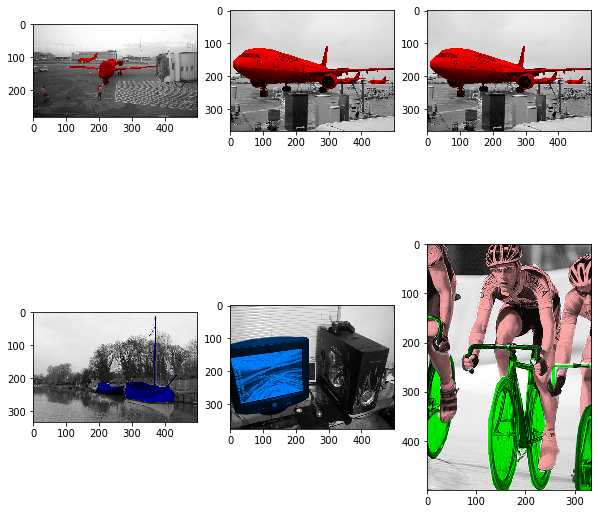


Loading deeplab network model...

Inference with deeplab network model...


In [392]:
if __name__ == '__main__':
    problem2()